In [133]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os

from astropy.io import fits

from scipy.optimize import least_squares

from uncertainties import *
from uncertainties.unumpy import *
from uncertainties.umath import *

from datetime import datetime

In [134]:
# Constants and values
xy_err = 0.5 # px
radec_err = 0.1 / 3600 # arcsec

pixel_size_m = 7.4e-6  # m

In [135]:
# Importing data
data = pd.read_csv('data/positions.csv')

data_unchanged = data.copy()

In [136]:
# Loading images
image_path = glob.glob(f"data/*.fits")

images = [fits.getdata(image_path) for image_path in image_path]

# Find the center of the image
x_center, y_center = (images[0].shape[1] // 2, images[0].shape[0] // 2)
print("Center of the image:", x_center, y_center)

# Convert coordinate system to have (0,0) at (x_center, y_center)
data['X'] = data['X'] - x_center
data['Y'] = data['Y'] - y_center 

Center of the image: 1028 1031


In [137]:
data

,ra,dec,X,Y
0,17:57:24.446,+04:36:08.11,264.5000,620.1667
1,17:57:29.108,+04:35:36.49,326.5000,544.0000
2,17:57:32.544,+04:35:31.50,349.0000,482.0000
3,17:57:34.962,+04:35:11.05,387.5000,445.5000
4,17:57:38.111,+04:35:12.71,399.5000,385.5000
5,17:57:32.401,+04:34:48.69,401.5000,497.5000
6,17:57:30.349,+04:34:25.14,422.5000,543.0000
7,17:57:24.988,+04:34:05.86,421.0000,647.0000
8,17:57:21.537,+04:33:43.02,432.5000,717.5000
9,17:57:34.667,+04:33:19.14,521.9536,485.6014


In [138]:
# Convert RA and Dec to decimal degrees
def ra_to_decimal(ra):
    h, m, s = map(float, ra.split(':'))

    return (h + m / 60 + s / 3600) * 15 

def dec_to_decimal(dec):
    d, m, s = map(float, dec.split(':'))
    
    return d + (m / 60) + (s / 3600) if d >= 0 else d - (m / 60) - (s / 3600)

# Convert decimal degrees to RA and Dec
def decimal_to_ra_hms(ra_decimal):
    total_seconds = ra_decimal / 15 * 3600  
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = total_seconds % 60

    return f"{hours:02}:{minutes:02}:{seconds:.3f}"

def decimal_to_dec_dms(dec_decimal):
    is_negative = dec_decimal < 0
    dec_decimal = abs(dec_decimal)
    degrees = int(dec_decimal)
    total_minutes = (dec_decimal - degrees) * 60
    minutes = int(total_minutes)
    seconds = (total_minutes - minutes) * 60
    sign = '-' if is_negative else '+'

    return f"{sign}{degrees:02}:{minutes:02}:{seconds:.2f}"

# Affine transformation 
def compute_transformation_params(data):
    RA = data['ra'].values
    Dec = data['dec'].values
    X = data['X'].values
    Y = data['Y'].values
    
    # Residuals for least squares
    def residuals(params):
        a, b, c, d = params
        X_transformed = a * X + b * Y + c
        Y_transformed = b * X - a * Y + d

        return np.concatenate([
            X_transformed - RA, 
            Y_transformed - Dec
        ])

    # Initial guess for [a, b, c, d]
    initial_params = [0, 0, 0, 0]
    result = least_squares(residuals, initial_params)

    params = result.x
    J = result.jac
    res = result.fun
    res_x = res[:len(X)]
    res_y = res[len(X):]
    res_var = np.mean(res**2)

    covariance_matrix = res_var * np.linalg.inv(J.T @ J)

    param_err = np.sqrt(np.diag(covariance_matrix))

    params_comb = [ufloat(params[i], param_err[i]) for i in range(4)]

    print(f"Transformation Parameters: "
          f"\n a = {params_comb[0]},"
          f"\n b = {params_comb[1]},"
          f"\n c = {params_comb[2]},"
          f"\n d = {params_comb[3]}")

    return params_comb , res_x, res_y
# Rotation angle
def calculate_rotation_angle(a, b):
    theta = arctan2(b, a)  
    theta_deg = 180 * theta / np.pi
    
    print(f"Rotation Angle: {theta_deg} degrees")

    return theta_deg  

# X, Y to RA, Dec
def transform_coordinates(X, Y, params):
    a, b, c, d = params

    X = ufloat(X, xy_err)
    Y = ufloat(Y, xy_err)

    RA = a * X + b * Y + c
    Dec = b * X - a * Y + d

    RA_hms = decimal_to_ra_hms(RA.nominal_value)
    RA_hms_err = decimal_to_ra_hms(RA.std_dev)
    Dec_dms = decimal_to_dec_dms(Dec.nominal_value)
    Dec_dms_err = decimal_to_dec_dms(Dec.std_dev)

    print(f"RA = {RA_hms} ± {RA_hms_err}")
    print(f"Dec = {Dec_dms} ± {Dec_dms_err}")
    
    return RA, Dec

# Calculate focal length of the telescope
def calculate_focal_length(pixel_size_m, resolution):
    focal_length = (pixel_size_m * 206265) / resolution

    print(f"Focal Length of the Telescope: {focal_length:.4f} meters")
    return focal_length

def calculate_year_difference(date1_str, date2_str):
    date_format = "%d.%m.%Y"
    date1 = datetime.strptime(date1_str, date_format)
    date2 = datetime.strptime(date2_str, date_format)
    
    difference_in_years = (date2 - date1).days / 365.25  # considering leap years

    print(f"Difference in years: {difference_in_years}")

    return difference_in_years

In [139]:
# Convert RA and Dec to decimal degrees
data['ra'] = data['ra'].apply(ra_to_decimal)
data['dec'] = data['dec'].apply(dec_to_decimal)

In [140]:
# Least squares fit
params_comb, res_x, res_y = compute_transformation_params(data)

Transformation Parameters: 
 a = (5.368+/-0.011)e-05,
 b = -0.00021284+/-0.00000011,
 c = 269.46954+/-0.00007,
 d = 4.69246+/-0.00007


In [141]:
# Rotation angle transformation
rotation_angle = calculate_rotation_angle(params_comb[0], params_comb[1])

Rotation Angle: -75.844+/-0.028 degrees


In [142]:
# Ra, Dec of the center
ra_center_comb, dec_center_comb = transform_coordinates(0, 0, params_comb)

RA = 17:57:52.691 ± 00:00:0.031
Dec = +04:41:32.86 ± +00:00:0.46


In [143]:
# Ra, Dec of Barnard's Star
x_barnard = 687.7441 - x_center
y_barnard = 1051.8191 - y_center

ra_barnard_comb, dec_barnard_comb = transform_coordinates(x_barnard, y_barnard, params_comb)

RA = 17:57:47.244 ± 00:00:0.032
Dec = +04:45:49.55 ± +00:00:0.48


In [144]:
# Calculate FOV
ra_min_comb, dec_min_comb = transform_coordinates(-x_center, -y_center, params_comb)
ra_max_comb, dec_max_comb = transform_coordinates(x_center, y_center, params_comb)

fov_ra = (ra_min_comb - ra_max_comb) * 3600
fov_dec = (dec_min_comb - dec_max_comb) * 3600

print(f"\nField of View: RA = {fov_ra}, Dec = {fov_dec}")

RA = 17:58:32.111 ± 00:00:0.048
Dec = +04:57:59.78 ± +00:00:0.73
RA = 17:57:13.271 ± 00:00:0.048
Dec = +04:25:5.95 ± +00:00:0.73

Field of View: RA = 1182.6+/-1.3, Dec = 1973.8+/-1.3


In [145]:
# Calculate resolution
resolution = sqrt(params_comb[0]**2 + params_comb[1]**2) * 3600

print(f"\nResolution: {resolution} arcsec/px") 


Resolution: 0.7902+/-0.0004 arcsec/px


In [146]:
# Calculate focal length
focal_length = calculate_focal_length(pixel_size_m, resolution)

Focal Length of the Telescope: 1.9316+/-0.0009 meters


In [147]:
# Calculate Ra Dec for all stars
ra_trans = []
dec_trans = []
ra_trans_err = []
dec_trans_err = []
for i, row in data.iterrows():
    ra, dec = transform_coordinates(row['X'], row['Y'], params_comb)
    ra_trans.append(ra.nominal_value)
    dec_trans.append(dec.nominal_value)
    ra_trans_err.append(ra.std_dev)
    dec_trans_err.append(dec.std_dev)


RA = 17:57:24.420 ± 00:00:0.035
Dec = +04:36:10.35 ± +00:00:0.53
RA = 17:57:29.109 ± 00:00:0.035
Dec = +04:35:37.56 ± +00:00:0.52
RA = 17:57:32.566 ± 00:00:0.034
Dec = +04:35:32.30 ± +00:00:0.52
RA = 17:57:34.927 ± 00:00:0.034
Dec = +04:35:9.86 ± +00:00:0.52
RA = 17:57:38.146 ± 00:00:0.034
Dec = +04:35:12.26 ± +00:00:0.51
RA = 17:57:32.451 ± 00:00:0.035
Dec = +04:34:49.08 ± +00:00:0.52
RA = 17:57:30.397 ± 00:00:0.036
Dec = +04:34:24.20 ± +00:00:0.53
RA = 17:57:25.065 ± 00:00:0.037
Dec = +04:34:5.25 ± +00:00:0.55
RA = 17:57:21.612 ± 00:00:0.038
Dec = +04:33:42.81 ± +00:00:0.56
RA = 17:57:34.610 ± 00:00:0.036
Dec = +04:33:19.09 ± +00:00:0.54
RA = 17:57:31.710 ± 00:00:0.037
Dec = +04:32:50.06 ± +00:00:0.55
RA = 17:57:29.321 ± 00:00:0.038
Dec = +04:32:7.00 ± +00:00:0.57
RA = 17:57:51.748 ± 00:00:0.032
Dec = +04:36:22.41 ± +00:00:0.49
RA = 17:57:49.605 ± 00:00:0.031
Dec = +04:42:24.80 ± +00:00:0.46
RA = 17:57:51.955 ± 00:00:0.031
Dec = +04:42:20.16 ± +00:00:0.46
RA = 17:57:54.419 ± 00:00:0.

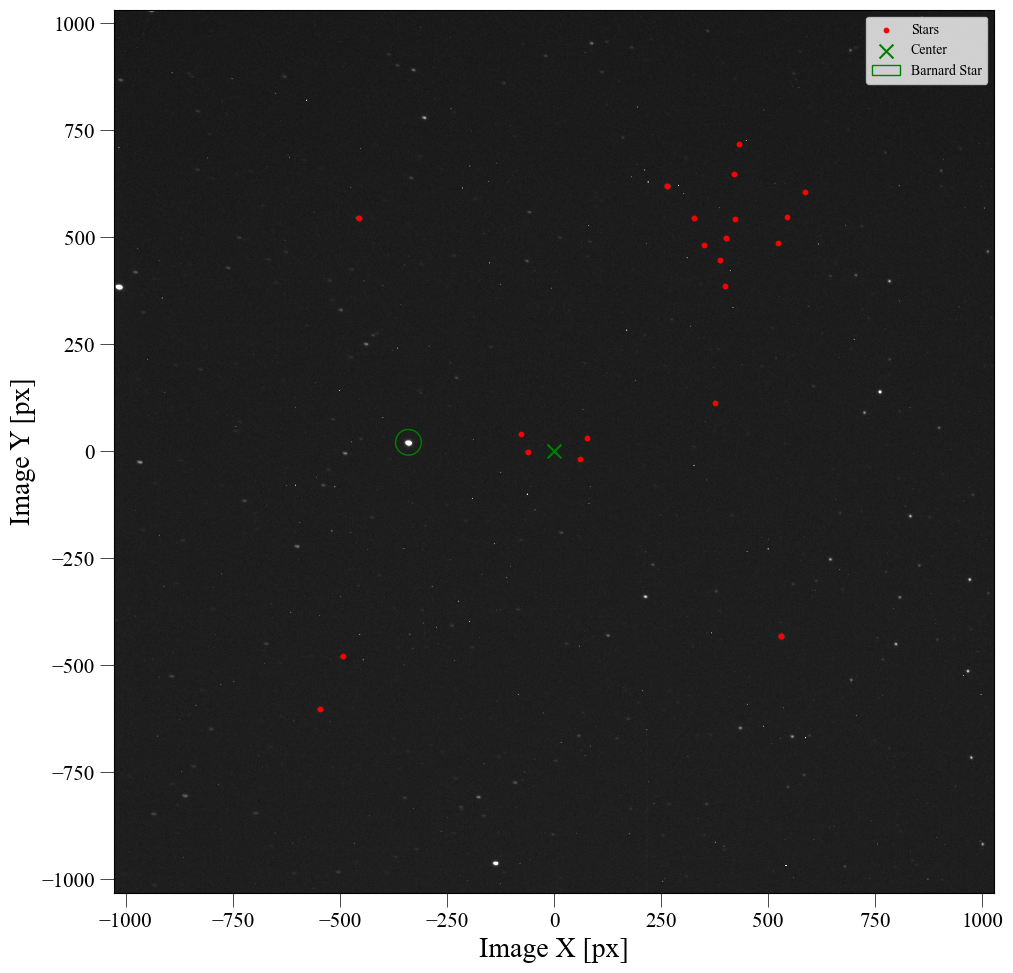

In [148]:
plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"

image = images[0]

vmin = 475
vmax = 1200

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('Image X [px]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Image Y [px]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.imshow(image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax, extent=[-x_center, x_center, -y_center, y_center])

ax.scatter(data['X'], data['Y'], c='r', s=10)
ax.scatter(0, 0, c='g', marker='x', s=100)

circle = plt.Circle((x_barnard, y_barnard), 30, color='g', fill=False)

plt.gca().add_patch(circle)

ax.legend(['Stars', 'Center', 'Barnard Star'], loc='upper right', fontsize=10)

plt.savefig('images/barnard_sky.png')

plt.show()

In [149]:
# Importing gaia data for Barnard's Star
gaia = pd.read_csv('data/star_table_Barnard.csv')

In [150]:
gaia

,SOURCE_ID,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,ruwe,nu_eff_used_in_astrometry,...,visibility_periods_used,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,phot_bp_rp_excess_factor,phot_g_mean_flux,duplicated_source,l,b
0,4472832130942575872,269.448503,0.026239,4.73942,0.029044,546.97594,0.040116,13634.737305,1.084851,1.25718,...,17,8.193974,9.791788,6.958091,2.833697,1.480381,9.939326e+06,False,31.049418,14.086604


In [151]:
# https://ui.adsabs.harvard.edu/abs/2011SASS...30..109B/abstract
ra_barnard_2009 = ufloat(269.44994707, 0.00000388) 
dec_barnard_2009 = ufloat(4.72076871, 0.00000576)

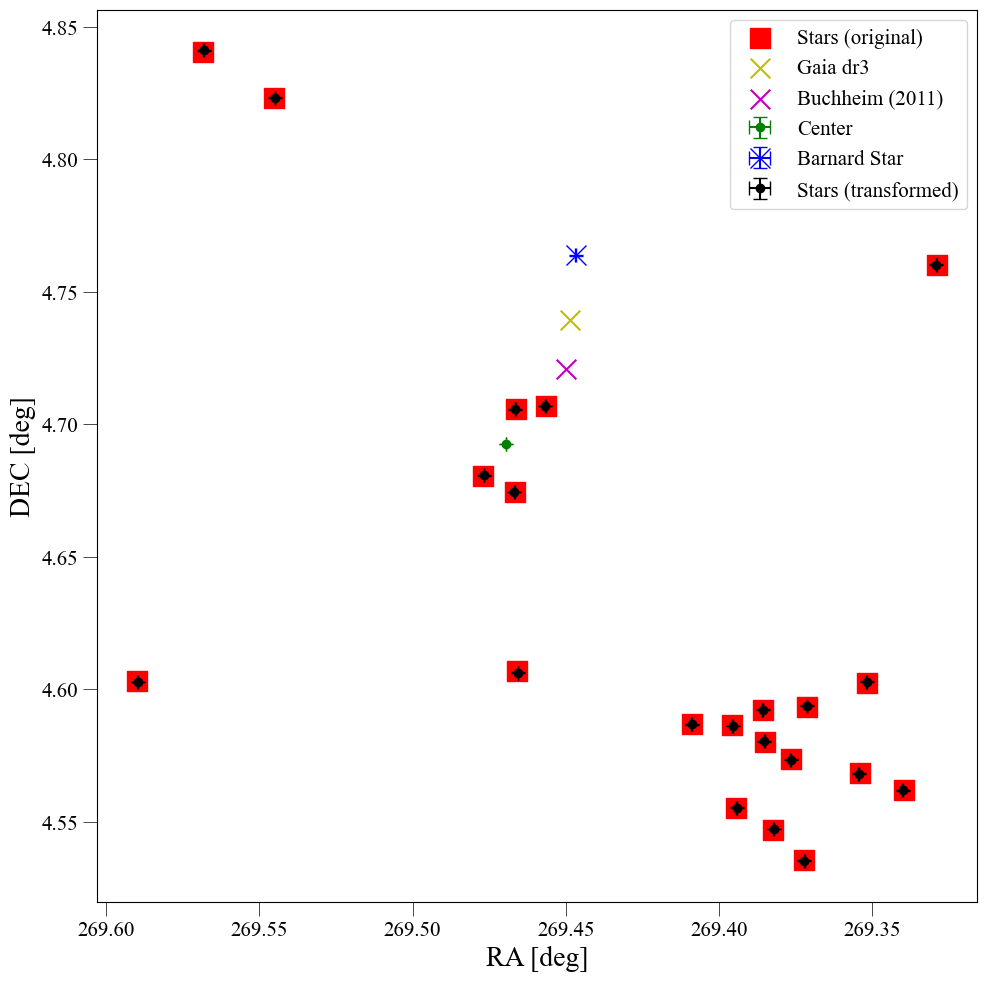

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('RA [deg]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('DEC [deg]')
ax.yaxis.label.set_fontsize(20)
ax.invert_xaxis()
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.scatter(data['ra'], data['dec'], c='r', s=200, marker='s', label='Stars (original)')

ax.errorbar(ra_center_comb.nominal_value, dec_center_comb.nominal_value, xerr=ra_center_comb.std_dev, yerr=dec_center_comb.std_dev, fmt='o', color='g', capsize=5, label='Center')

ax.errorbar(ra_barnard_comb.nominal_value, dec_barnard_comb.nominal_value, xerr=ra_barnard_comb.std_dev, yerr=dec_barnard_comb.std_dev, fmt='x', markersize=15, color='b', capsize=5, label='Barnard Star')

ax.errorbar(ra_trans, dec_trans, xerr=ra_trans_err, yerr=dec_trans_err, fmt='o', color='black', capsize=5, label='Stars (transformed)')

ax.scatter(gaia['ra'], gaia['dec'], c='y', s=200, marker='x', label='Gaia dr3')

ax.scatter(ra_barnard_2009.nominal_value, dec_barnard_2009.nominal_value, c='m', s=200, marker='x', label='Buchheim (2011)')

ax.legend(loc='upper right', fontsize=15)

plt.savefig('images/barnard_radec.png')

plt.show()

In [153]:
# Calculate proper motion
ra_dist = (ra_barnard_comb - ra_barnard_2009) * 3600 * 10**3
dec_dist = (dec_barnard_comb - dec_barnard_2009) * 3600 * 10**3

date1 = "27.06.2009"
date2 = "01.05.2024"

time_diff = {calculate_year_difference(date1, date2)}
time_diff = list(time_diff)[0]

proper_motion_ra = ra_dist / time_diff 
proper_motion_dec = dec_dist / time_diff

print(f"Proper Motion in RA: {proper_motion_ra:.2f} mas/y")
print(f"Proper Motion in Dec: {proper_motion_dec:.2f} mas/y")

Difference in years: 14.844626967830253
Proper Motion in RA: -751.53+/-32.40 mas/y
Proper Motion in Dec: 10426.87+/-32.41 mas/y


In [154]:
data_unchanged['res_x'] = [f"{x:.4e}" for x in res_x]
data_unchanged['res_y'] = [f"{y:.4e}" for y in res_y]

data_unchanged.to_csv('data/positions_with_residuals.csv', index=False)